In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

torch.Size([1, 1, 28, 28]) tensor([9])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    

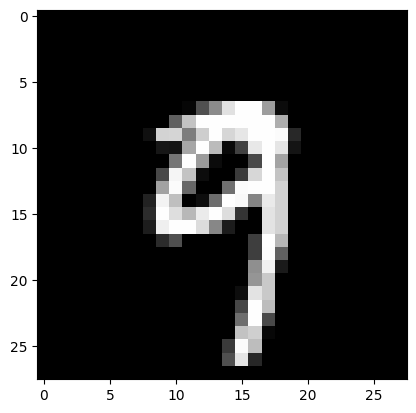

In [131]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

# mnist_train.data.to('cuda')
# mnist_train.targets.to('cuda')
# # mnist_test.data.to('cuda')
# mnist_test.data.to('cuda')
# mnist_test.targets.to('cuda')
# mnist_test.labels
# create a dataloader with
#  batch size 1
mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=2048, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

In [695]:
class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        
        self.p_c = nn.Parameter(nn.init.normal_(torch.empty(out_features//branch_factor, branch_factor))) # might do log softmax?
        self.p_x_given_c = nn.Linear(n_hidden, out_features, bias=True)
        # self.p_c = nn.Sequential(
        #     nn.Linear(out_features//branch_factor, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        # self.p_x_given_c = nn.Sequential(
        #     nn.Linear(n_hidden, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        # self.activation = nn.ReLU()

    def forward(self, x, f):
        # z_expanded = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)
        f = f.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(f.size(0), -1)

        p_c = f + self.p_c.flatten()
        # p_c = z_expanded + self.p_c(z)
        p_x_given_c = self.p_x_given_c(x)

        f = p_x_given_c + p_c
        # f = self.logsoftmax(f)
        return f
    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(64, 64, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.activation = nn.LogSoftmax(dim=1)

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor) for i in range(1, n_layers + 1)]
        )

        # self.predict_layer = nn.Linear(sum([branch_factor ** i for i in range(n_layers+1)])-1, 10)
        # self.reconstruction_layer = nn.Linear(sum([branch_factor ** i for i in range(n_layers+1)])-1, n_hidden)
        
        self.predict_layer = nn.Linear(branch_factor ** n_layers, 10, bias=False)
        self.reconstruction_layer = nn.Linear(branch_factor ** n_layers, n_hidden, bias=False)

        #self.CNN = SimpleCNN()

    def forward(self, x):
        layer_outputs = []
        in_shape = x.shape
        x = x.view(-1, self.n_hidden)
        # print(x.shape)
        # x = self.CNN(x)
        # print(f"range of x: {x.min()}, {x.max()}")

        z = torch.zeros((x.size(0), 1), device=x.device)
        for layer in self.layers:
            z = self.activation(layer(x, z))
            # layer_outputs.append(z)
        
        # layer_outputs = torch.cat(layer_outputs, dim=1)

        # return z, self.predict_layer(z), self.reconstruction_layer(z)
        # return z, self.predict_layer(layer_outputs), self.reconstruction_layer(layer_outputs)
        
        yh = self.predict_layer.weight.T.unsqueeze(0).expand(z.shape[0], z.shape[1], -1)
        xh = self.reconstruction_layer.weight.T.unsqueeze(0).expand(z.shape[0], z.shape[1], -1).reshape(z.shape[0], z.shape[1], in_shape[1], in_shape[2], in_shape[3])
        
        return z, yh, xh

In [850]:
def cobweb_ce_loss(z, yh, y, xh, x):
    # z shape => N x C (these should be log probs)
    # yh shape => N x C x D (these should be log probs)
    # y shape => N (the class indices)
    # xh shape => N x C x 1x28x28 (image outputs from each leaf for each example)
    # x shape => N x 1x28x28 (images)

    y_unsqueezed = y.view(-1, 1, 1).expand(-1, z.shape[1], 1)  # Shape: (N, C, 1)
    log_p_of_y = F.log_softmax(yh, dim=2).gather(2, y_unsqueezed).squeeze(-1)  # Final shape: (N, C)
    # log_p_of_x = -0.5 * torch.pow(x.unsqueeze(1).expand(xh.shape) - xh, 2).mean(dim=(2,3,4))

    #weighted_ll = torch.exp(z)*log_p_of_y
    #return -weighted_ll.sum(dim=1).mean(dim=0)
    
    ll = z + log_p_of_y #  + log_p_of_x
    return -ll.logsumexp(dim=1).mean(dim=0)


In [834]:
def train_model(model, train_data=None, optimizer=None, device='cuda',
                batch_size=32, epochs=1,
                show_loss=False, show_centroids=False,
                show_filters=False, show_decision_boundary=False, verbose=True, early_break=False):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        N = 0
        i = 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
            for x, y in t:
                i += 1
                optimizer.zero_grad()
    
                outputs = model(x.to(device))

                z, yh, xh = model(x)

                #loss = F.cross_entropy(yh, y)
                #loss += F.mse_loss(xh, x.reshape(x.shape[0], -1))
                # Compute the weighted cross-entropy loss
                loss = cobweb_ce_loss(z, yh, y, xh, x)
                
                losses.append(loss.item())
    
                if verbose:
                    print(f"layer outputs: {outputs.layer_outputs}")
                
                loss.backward()
                optimizer.step()
    
                epoch_loss += loss.item() * x.shape[0]
                N += x.shape[0]
                t.set_postfix({"AvgLoss": epoch_loss/N})
                # t.set_postfix(loss=loss.item())
                if early_break:
                    break 

    if show_loss:
        plt.plot(losses)
        plt.show()

Epoch 3/3: 100%|██████████████| 30/30 [00:01<00:00, 16.64it/s, AvgLoss=0.442]


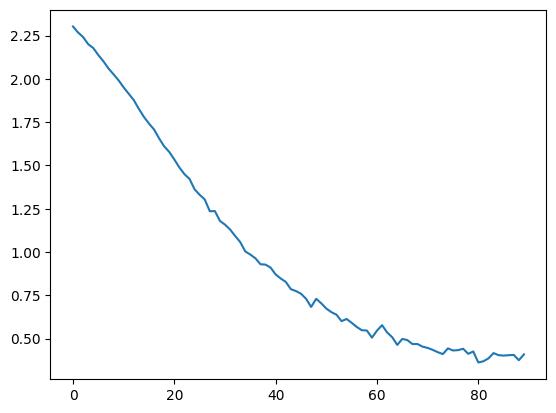

In [851]:
device = "cpu"
n_layers = 4
model = CobwebNN(n_layers=n_layers, branch_factor=3, n_hidden=784).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-2)

train_model(model, mnist_train, optimizer, epochs=3, batch_size=2048, show_loss=True, device=device, verbose=False, early_break=False)

In [847]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-3
train_model(model, mnist_train, optimizer, epochs=10, batch_size=2048, show_loss=True, device=device, verbose=False, early_break=False)

Epoch 2/10:  17%|██▏          | 5/30 [00:01<00:06,  3.70it/s, AvgLoss=0.0317]


KeyboardInterrupt: 

In [852]:
device = "cpu"

# Visualize learned encoding
labels = []
all_data = []
layer_outputs = []

model.eval()
model.to(device)

correct_predictions = []
for i, (data, target) in enumerate(tqdm(mnist_test_loader)):
    data = data.to(device)
    target = target.to(device)
    #data[:,:, 0, :] = 0.0
    #data[:,:, 0, target] = 1.0
    all_data.extend(data)
    z, yh, xh = model(data)
    layer_outputs.append(z)

    #log_p_of_x = -0.5 * torch.pow(data.unsqueeze(1).expand(xh.shape) - xh, 2).sum(dim=(2,3,4))
    z_best = torch.argmax(z, dim=1).unsqueeze(1).unsqueeze(1).expand(yh.shape[0], 1, yh.shape[2])
    predictions = torch.argmax(yh.gather(1, z_best).squeeze(1), dim=1)
    
    z_expanded = torch.exp(z).unsqueeze(1)  # Shape: (N, 1, C)
    yh = torch.matmul(z_expanded, yh).squeeze(1)
    predictions = torch.argmax(yh, dim=1)
    
    correct_predictions.append((predictions == target).float())  # Number of correct predictions
    
    labels.append(target)

# Compute accuracy
correct_predictions = torch.cat(correct_predictions)
accuracy = correct_predictions.mean().item()
print("Test Accuracy", accuracy)

#print(all_outputs[0])
all_data = torch.stack(all_data).view(-1, 784)
layer_outputs = torch.cat(layer_outputs).detach().numpy()

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.92it/s]

Test Accuracy 0.9355999827384949


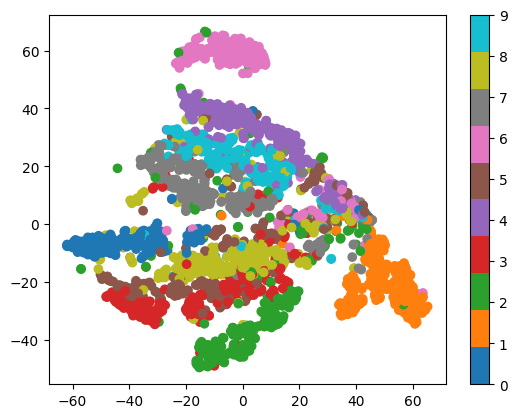

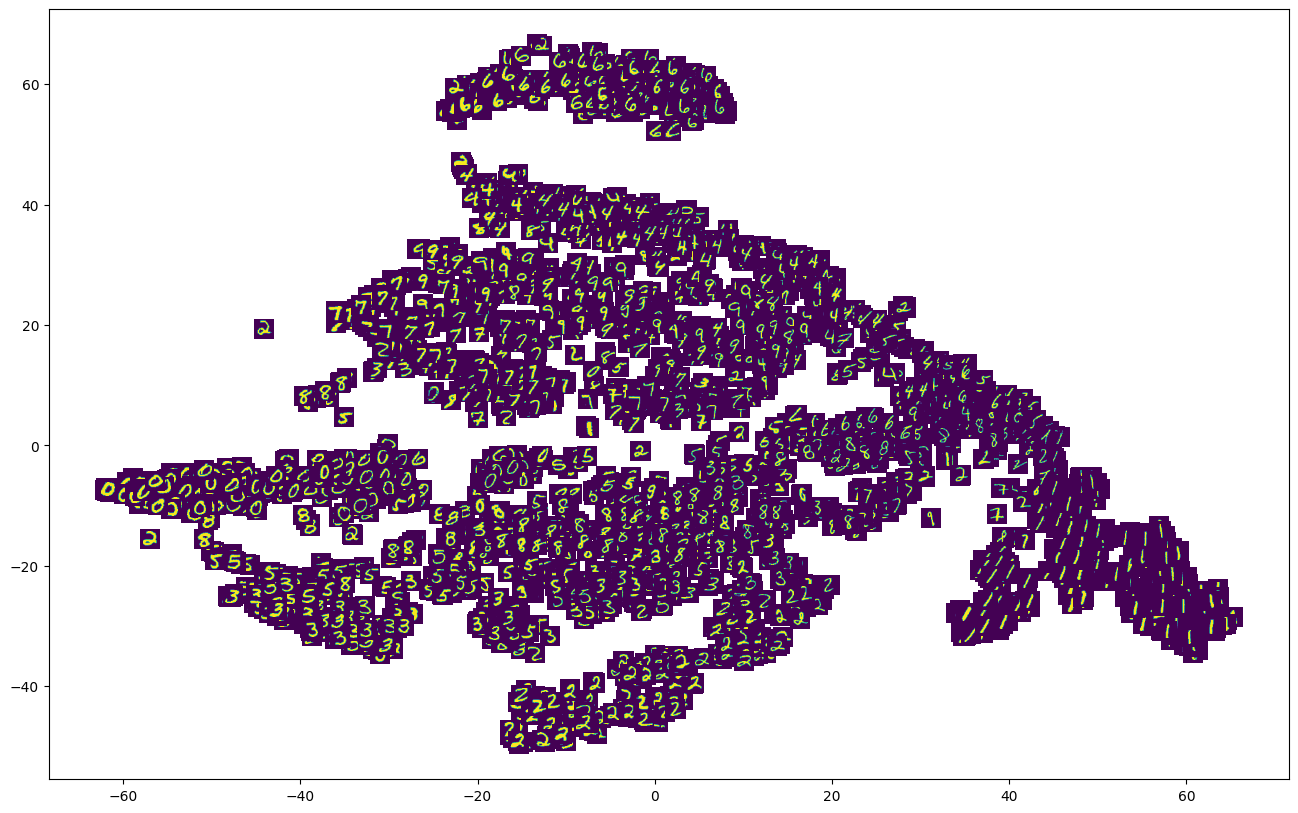

In [853]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# do tsne on the outputs for the last layer
tnse_samples = 3000
tsne = TSNE(n_components=2)
tsne_outputs = tsne.fit_transform(layer_outputs[:tnse_samples])

tsne_labels = torch.cat(labels, dim=0)[:tnse_samples].cpu().numpy()
plt.scatter(tsne_outputs[:, 0], tsne_outputs[:, 1], c=tsne_labels, cmap='tab10')
plt.colorbar()
plt.show()

img_w, img_h = 28,28
zoom = 0.5

fig, ax = plt.subplots(figsize=(16,10))
for i in range(tsne_outputs.shape[0]):
    # image = row[pixel_cols].values.astype(float).reshape((img_w, img_h))
    image = all_data[i].reshape((img_w, img_h)).cpu()
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (tsne_outputs[i][0], tsne_outputs[i][1]), xycoords='data', frameon=False)
    ax.add_artist(ab)
    ax.update_datalim([(tsne_outputs[i][0], tsne_outputs[i][1])])
    ax.autoscale()